In [4]:
#import everything here
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
from vireoSNP import BinomMixtureVB

from mquad.mquad_utils import findKnee, plot_confusionMatrix, confusionMatrix

print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


In [5]:
mquad_AD = mmread('data/mquad/passed_ad.mtx').tocsc()
mquad_DP = mmread('data/mquad/passed_dp.mtx').tocsc()

mquad_AD.shape, mquad_DP.shape

((146, 121), (146, 121))

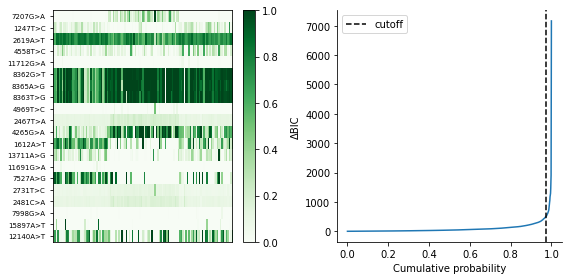

In [6]:
with open('data/mquad/passed_variant_names.txt') as f:
    var = f.readlines()

var = [x.strip() for x in var]

AD_df = pd.DataFrame(mquad_AD.todense(), index=var)
DP_df = pd.DataFrame(mquad_DP.todense(), index=var)


##flip the AF for 2619T>A, 8362T>G, 8365G>A, 8363G>T
flip_var = ['2619A>T', '8362G>T', '8365A>G', '8363T>G']

for v in flip_var:
    AD_df.loc[v] = DP_df.loc[v] - AD_df.loc[v]

AF_df = AD_df/DP_df
AF_df = AF_df.fillna(0)

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
res = plt.imshow(AF_df[0:20], cmap = 'Greens', aspect = 'auto', interpolation = 'none')
plt.yticks(range(20), var[0:20], fontsize = 7)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
cb = plt.colorbar(res)

ax = plt.subplot(1,2,2)
BIC = pd.read_csv('data/mquad/BIC_params.csv')
x,y,knee,knee_y = findKnee(BIC.deltaBIC)
plt.plot(x, y)
plt.axvline(x=knee, color="black", linestyle='--',label="cutoff")
plt.legend()
plt.ylabel("\u0394BIC")
plt.xlabel("Cumulative probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()


In [7]:
#fit on mquad output
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=3)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

Precision = 0.9309523809523809
Recall = 0.9315565565565566


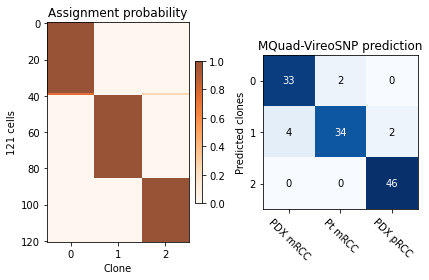

In [8]:
#assignment prob heatmap
from vireoSNP.plot.base_plot import heat_matrix
plt.subplot(1,2,1)
im = heat_matrix(mquad_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()


#mquad confusion matrix
ax = plt.subplot(1,2,2)
clone_id = np.argmax(mquad_modelCA.ID_prob, axis=1)

clone_id[clone_id == 1] = 3
clone_id[clone_id == 0] = 1
clone_id[clone_id == 2] = 0
clone_id[clone_id == 3] = 2

real_lab = ['PDX mRCC'] * 37 + ['PDX pRCC'] * 48 + ['Pt mRCC'] * 36
confusion = confusionMatrix(clone_id, real_lab)
confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('Predicted clones')
plt.xticks(range(3), confusion.columns,rotation=315)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()

In [9]:
import vireoSNP
from vireoSNP.utils.io_utils import read_sparse_GeneINFO
from vireoSNP.utils.vcf_utils import load_VCF, write_VCF, parse_donor_GPb

mgatk = pd.read_csv('data/mgatk/final/misc_df.csv')
mgatk[['ref', 'alt']] = mgatk.nucleotide.str.split('>', expand=True)
mgatk['mquad_variant_name'] = 'chrM_' + mgatk.position.astype(str) + '_' + mgatk.ref + '_' + mgatk.alt
filt = mgatk[(mgatk.strand_correlation >= 0.65) & (np.log10(mgatk.vmr) >= -2) & (mgatk.n_cells_conf_detected >= 5)]
mgatk_var = filt['Unnamed: 0']
cell_vcf = vireoSNP.load_VCF("data/cellsnp/cellSNP.cells.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])
AD, DP = cell_dat['AD'], cell_dat['DP']
variants=cell_vcf['variants']
inter_var = list(set(filt.mquad_variant_name) & set(variants))

idx = [variants.index(i) for i in inter_var]
mgatk_AD = AD[idx]
mgatk_DP = DP[idx]

mgatk_AD.shape, mgatk_DP.shape

/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


((273, 121), (273, 121))

In [10]:
_model = BinomMixtureVB(n_var=len(mgatk_AD.getnnz(axis=1)), n_cell=len(mgatk_AD.getnnz(axis=0)), n_donor=3)
_model.fit(mgatk_AD, mgatk_DP, min_iter=30, n_init=300)

mgatk_modelCA = _model

Precision = 0.6363835856923415
Recall = 0.7139014014014013


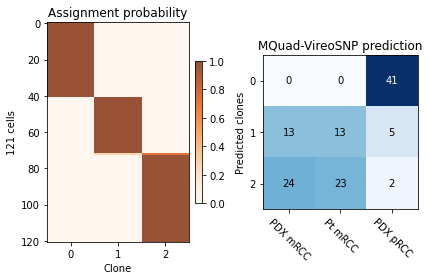

In [11]:
plt.subplot(1,2,1)
im = heat_matrix(mgatk_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mgatk_modelCA.n_cell))
plt.xticks(range(mgatk_modelCA.n_donor))
plt.tight_layout()


#mquad confusion matrix
ax = plt.subplot(1,2,2)
clone_id = np.argmax(mgatk_modelCA.ID_prob, axis=1)
real_lab = ['PDX mRCC'] * 37 + ['PDX pRCC'] * 48 + ['Pt mRCC'] * 36
confusion = confusionMatrix(clone_id, real_lab)
confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('Predicted clones')
plt.xticks(range(3), confusion.columns,rotation=315)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()

Precision = 0.9309523809523809
Recall = 0.9315565565565566
Precision = 0.6363835856923414
Recall = 0.7139014014014013


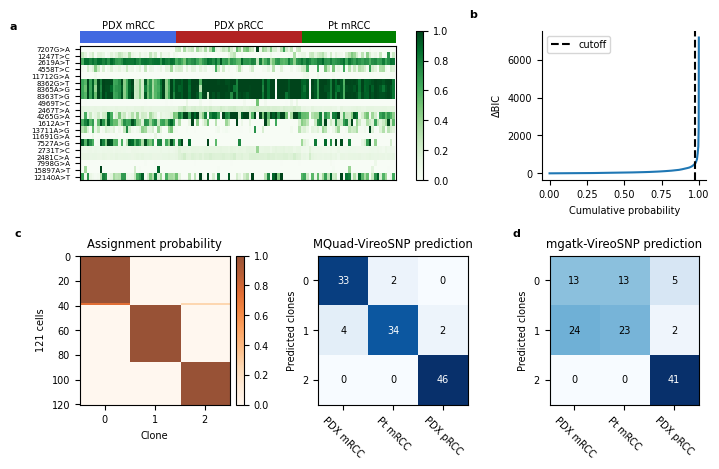

In [12]:
## put everything tgt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
plt.style.use('default')
font = {'family' : 'sans-serif',
        'size'   : 7}
plt.rc('font', **font)
cm = 1/2.54
fig = plt.figure(figsize=(18.3*cm, 12*cm), dpi=100)


#AF heatmap
ax = plt.subplot2grid((2,3), (0,0), colspan=2)
ax.text(-0.5*cm, 3*cm, 'a', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
res = ax.imshow(AF_df[0:20], cmap = 'Greens', aspect = 'auto', interpolation = 'none')
ax.set_yticks(range(20))
ax.set_yticklabels(var[0:20], fontsize = 5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.colorbar(res)

divider = make_axes_locatable(ax)
top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax)
label_num = [37,48,36]
LEFT = 0
iicolor = 0
c_names = ['PDX mRCC', 'PDX pRCC', 'Pt mRCC']
clone_pal = ['royalblue', 'firebrick', 'green']
for num in label_num:
        top_ax.barh(0,num,left=LEFT,color=clone_pal[iicolor])
        top_ax.text(x=LEFT + num/2, y=0.8, s=c_names[iicolor], va='center', ha='center')
        top_ax.set_xlim(0,120)
        top_ax.axis('off')
        LEFT += num
        iicolor += 1

## BIC curve
ax = plt.subplot2grid((2,3), (0,2), colspan=1)
ax.text(-1*cm, 2.9*cm, 'b', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
plt.plot(x, y)
plt.axvline(x=knee, color="black", linestyle='--',label="cutoff")
plt.legend()
plt.ylabel("\u0394BIC")
plt.xlabel("Cumulative probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#assignment prob heatmap
from vireoSNP.plot.base_plot import heat_matrix
ax = plt.subplot2grid((2,3), (1,0), colspan=1)
ax.text(-1*cm, 3*cm, 'c', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
im = heat_matrix(mquad_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()


#mquad confusion matrix
ax = plt.subplot2grid((2,3), (1,1), colspan=1)
clone_id = np.argmax(mquad_modelCA.ID_prob, axis=1)

#rearrange orders
clone_id[clone_id == 1] = 3
clone_id[clone_id == 0] = 1
clone_id[clone_id == 2] = 0
clone_id[clone_id == 3] = 2

real_lab = ['PDX mRCC'] * 37 + ['PDX pRCC'] * 48 + ['Pt mRCC'] * 36
confusion = confusionMatrix(clone_id, real_lab)
confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('Predicted clones')
plt.xticks(range(3), confusion.columns,rotation=315)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()


#mgatk confusion matrix
ax = plt.subplot2grid((2,3), (1,2), colspan=1)
ax.text(-0.5*cm, 3*cm, 'd', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
clone_id = np.argmax(mgatk_modelCA.ID_prob, axis=1)

#reaarange the orders to tidy up
clone_id[clone_id == 0] = 3
clone_id[clone_id == 1] = 0
clone_id[clone_id == 2] = 1
clone_id[clone_id == 3] = 2

confusion = confusionMatrix(clone_id, real_lab)
confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('mgatk-VireoSNP prediction')
plt.ylabel('Predicted clones')
plt.xticks(range(3), confusion.columns,rotation=315)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()


#plt.savefig('figures/Figure_1.pdf')

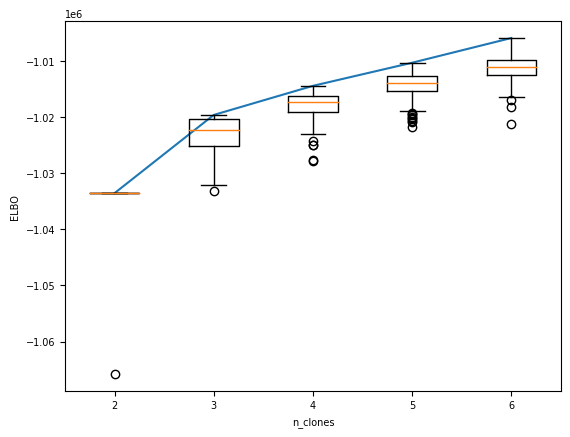

In [13]:
## extended analysis with SCITE

#find the suitable number of clones 
n_init = 300
n_clone_list = np.arange(2, 7)

_ELBO_mat = []
for k in n_clone_list:
    _model = BinomMixtureVB(n_var=mquad_AD.shape[0], n_cell=mquad_AD.shape[1], n_donor=k)
    _model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=n_init)
    _ELBO_mat.append(_model.ELBO_inits)
plt.plot(np.arange(1, len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(np.arange(1, len(n_clone_list)+1), n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

Precision = 0.8394612794612794
Recall = 0.6966341341341341


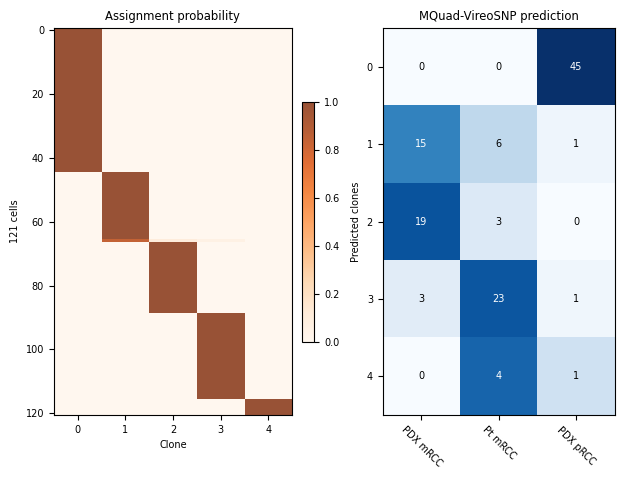

In [14]:
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=5)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

plt.subplot(1,2,1)
im = heat_matrix(mquad_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

#mquad confusion matrix
ax = plt.subplot(1,2,2)
clone_id = np.argmax(mquad_modelCA.ID_prob, axis=1)
real_lab = ['PDX mRCC'] * 37 + ['PDX pRCC'] * 48 + ['Pt mRCC'] * 36
confusion = confusionMatrix(clone_id, real_lab)
confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('Predicted clones')
plt.xticks(range(3), confusion.columns,rotation=315)
plt.yticks(range(len(confusion)), set(clone_id))
plt.tight_layout()

In [27]:
## visualize mgatk output

mgatk = pd.read_csv('data/mgatk/final/misc_df.csv')
mgatk[['ref', 'alt']] = mgatk.nucleotide.str.split('>', expand=True)
mgatk['mquad_variant_name'] = 'chrM_' + mgatk.position.astype(str) + '_' + mgatk.ref + '_' + mgatk.alt
mgatk['is_detected_by_mquad'] = mgatk.variant.isin(var)

In [39]:
mgatk.head()

,Unnamed: 0,position,nucleotide,variant,vmr,mean,variance,n_cells_conf_detected,n_cells_over_5,n_cells_over_10,n_cells_over_20,strand_correlation,mean_coverage,ref,alt,mquad_variant_name,is_detected_by_mquad
0,1G>A,1,G>A,1G>A,0.000000,0.000000,0.000000,0,0,0,0,NaN,14.198347,G,A,chrM_1_G_A,False
1,3T>A,3,T>A,3T>A,0.009434,0.001110,0.000010,0,1,1,1,NaN,14.884298,T,A,chrM_3_T_A,False
2,4C>A,4,C>A,4C>A,0.000000,0.000000,0.000000,0,0,0,0,NaN,15.041322,C,A,chrM_4_C_A,False
3,6C>A,6,C>A,6C>A,0.000000,0.000000,0.000000,0,0,0,0,NaN,15.520661,C,A,chrM_6_C_A,False
4,8G>A,8,G>A,8G>A,0.004732,0.000501,0.000002,0,0,0,0,NaN,16.504132,G,A,chrM_8_G_A,False


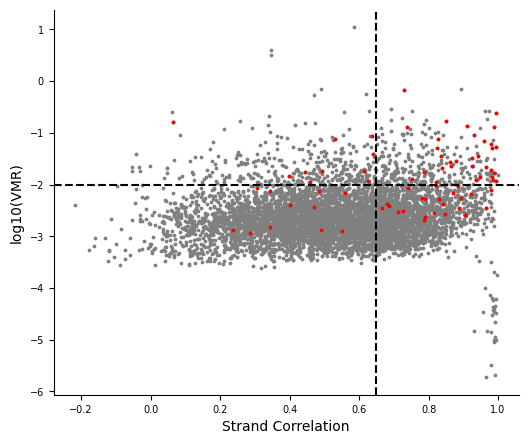

In [44]:
## only show n_cells_conf_detected > 5
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
mgatk_plot = mgatk[(mgatk.n_cells_conf_detected > 5) & (mgatk.mean_coverage > 50)]
plt.scatter(mgatk_plot.strand_correlation, np.log10(mgatk_plot.vmr), color='grey', s=3)
plt.scatter(mgatk_plot[mgatk_plot.is_detected_by_mquad == True].strand_correlation, np.log10(mgatk_plot[mgatk_plot.is_detected_by_mquad == True].vmr), color='red', s=3)
plt.axhline(y=-2, linestyle='--', color='black')
plt.axvline(x=0.65, linestyle='--', color='black')
plt.ylabel('log10(VMR)', fontsize=10)
plt.xlabel('Strand Correlation', fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/mgatk_plot.png')
